<a href="https://colab.research.google.com/github/losirlu1411/project-/blob/main/tuberculosis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data_directory= Path("/content/drive/MyDrive/project /TB_Chest_Radiography_Database/")
data_directory

PosixPath('/content/drive/MyDrive/project /TB_Chest_Radiography_Database')

In [3]:
#Get the path to the normal and pneumonia sub-directories
normal_cases_dir = data_directory / 'Normal'
Tuberculosis_cases_dir = data_directory / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases = Tuberculosis_cases_dir.glob('*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in Tuberculosis_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/MyDrive/project /TB_Chest_Radio...,1
1,/content/drive/MyDrive/project /TB_Chest_Radio...,0
2,/content/drive/MyDrive/project /TB_Chest_Radio...,0
3,/content/drive/MyDrive/project /TB_Chest_Radio...,0
4,/content/drive/MyDrive/project /TB_Chest_Radio...,0


In [4]:
train_data.shape

(4210, 2)

label
0    3500
1     710
Name: count, dtype: int64


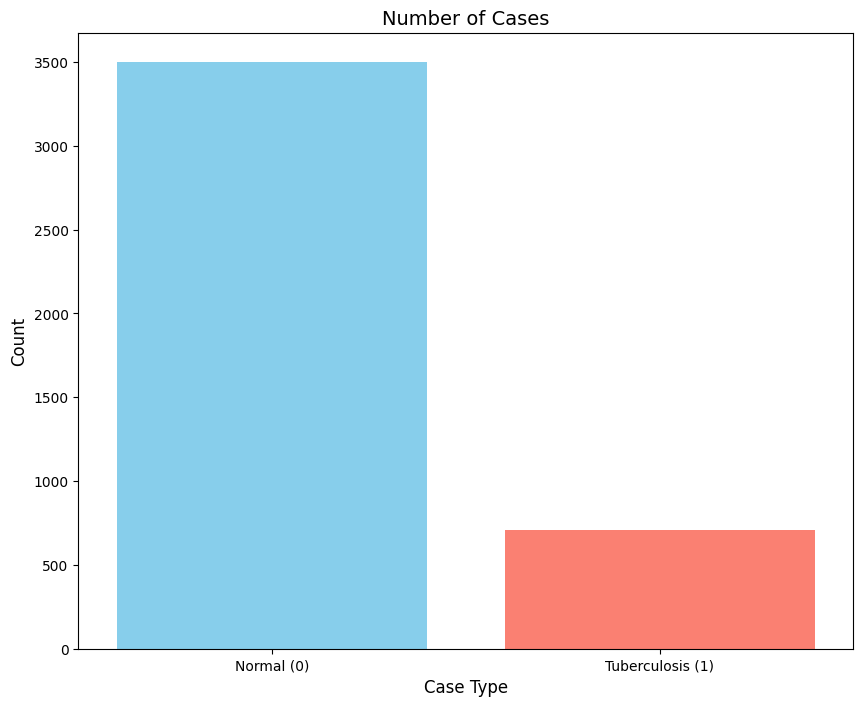

In [5]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Define custom colors for each class
class_colors = ['skyblue', 'salmon']  # Colors for 'Normal' and 'Tuberculosis'

# Plot the results
plt.figure(figsize=(10, 8))
bars = sns.barplot(x=cases_count.index, y=cases_count.values)

# Apply colors manually to the bars
for i, bar in enumerate(bars.patches):
    bar.set_facecolor(class_colors[i])

plt.title('Number of Cases', fontsize=14)
plt.xlabel('Case Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Tuberculosis (1)'])
plt.show()


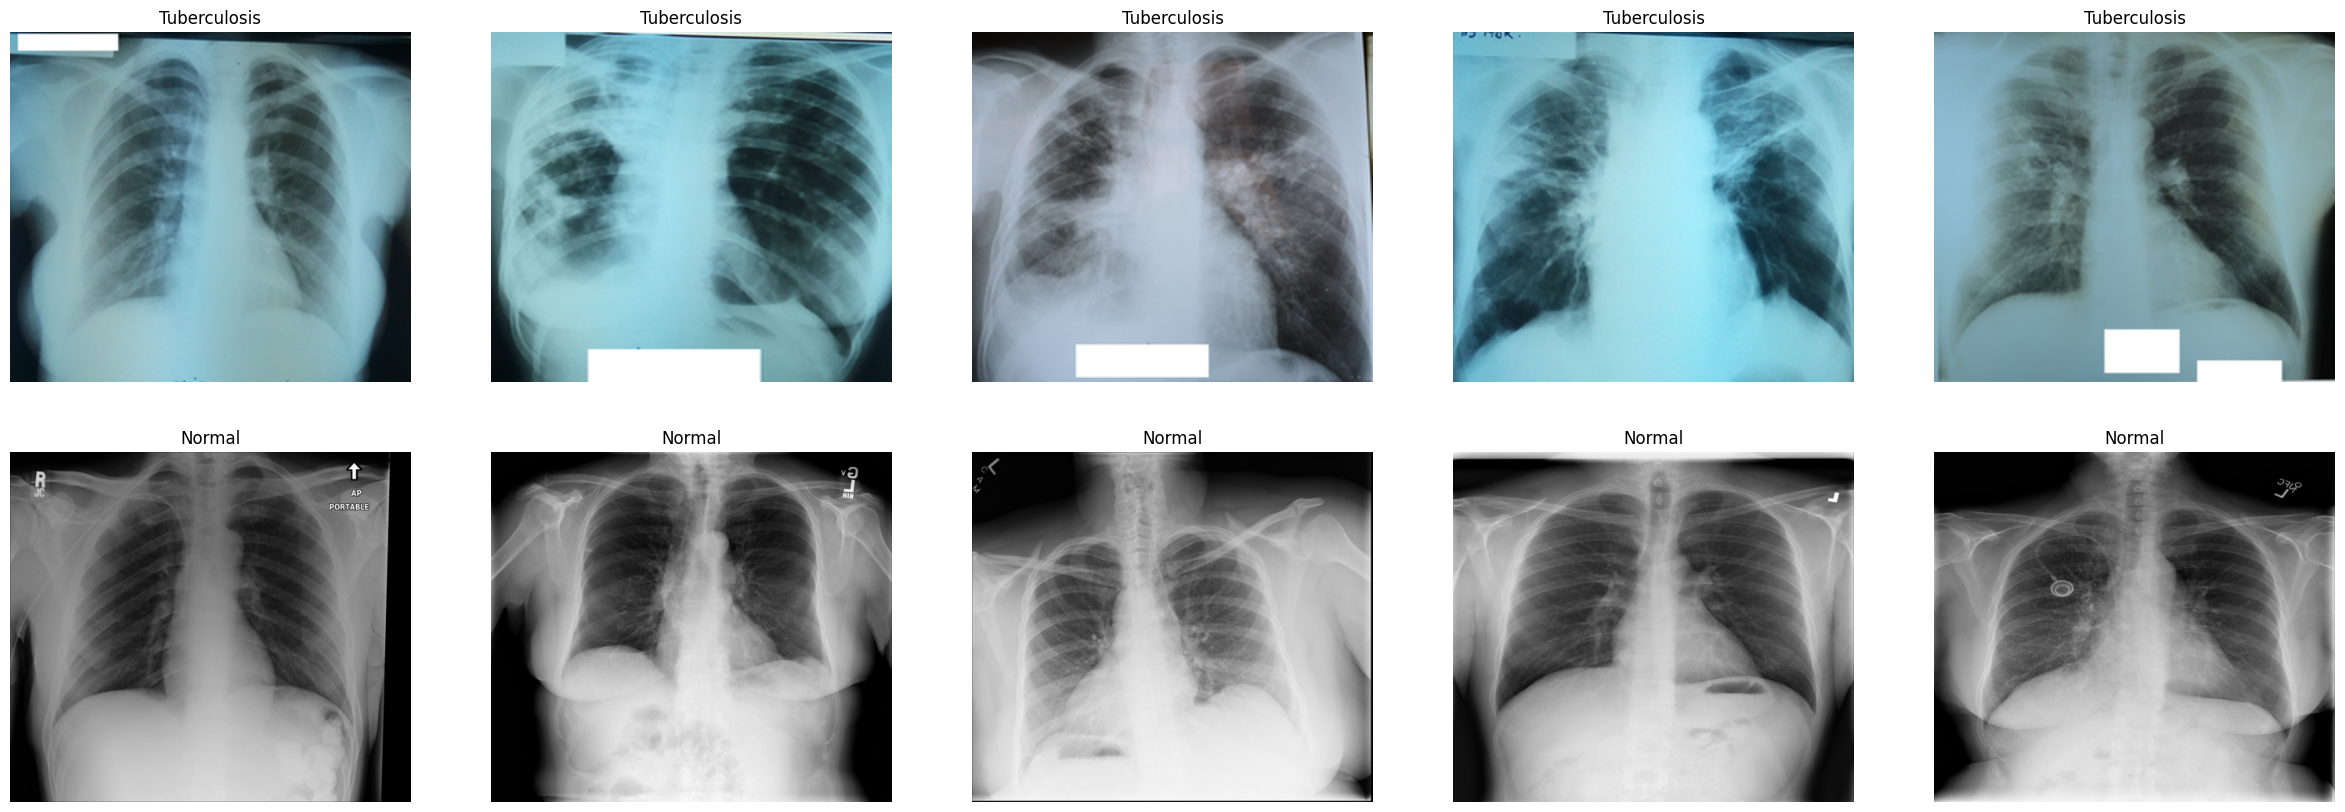

In [6]:
# Get few samples for both the classes
Tuberculosis_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Tuberculosis_samples + normal_samples
del Tuberculosis_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Tuberculosis")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()


In [7]:
train_normal = data_directory / 'Normal'
train_Tuberculosis = data_directory / 'Tuberculosis'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
Tuberculosis_cases =Tuberculosis_cases_dir.glob('*.png')
train_data = []
train_labels = []

#Normal Cases
for img in tqdm(normal_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'normal'
    train_data.append(img)
    train_labels.append(label)

# Tuberculosis cases
for img in tqdm(Tuberculosis_cases):
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=np.array(img)
    img = img/255
    label = 'Tuberculosis'
    train_data.append(img)
    train_labels.append(label)

# Convert the list into numpy arrays

train_data1 = np.array(train_data)
train_labels1 = np.array(train_labels)

print("Total number of validation examples: ", train_data1.shape)
print("Total number of labels:", train_labels1.shape)

3500it [02:03, 28.43it/s]
710it [00:14, 48.03it/s]


Total number of validation examples:  (4210, 224, 224, 3)
Total number of labels: (4210,)


In [8]:
train_data1[1]

array([[[0.01568627, 0.01568627, 0.01568627],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.01568627, 0.01568627, 0.01568627],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.01568627, 0.01568627, 0.01568627],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0

In [9]:
train_labels1 = pd.DataFrame(train_labels1, columns=[ 'label'],index=None)
train_labels1.head()

,label
0,normal
1,normal
2,normal
3,normal
4,normal


In [10]:
train_labels1['label']=train_labels1['label'].map({'normal':0,'Tuberculosis':1})
train_labels1['label'].unique()

array([0, 1])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.8230 - loss: 0.4448 - val_accuracy: 0.8907 - val_loss: 0.3220
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8969 - loss: 0.3191 - val_accuracy: 0.9002 - val_loss: 0.2934
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9033 - loss: 0.2871 - val_accuracy: 0.9002 - val_loss: 0.2863
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8254 - loss: 0.4868 - val_accuracy: 0.8314 - val_loss: 0.3850
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8251 - loss: 0.3919 - val_accuracy: 0.8349 - val_loss: 0.3894
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8762 - loss: 0.3077 - val_accuracy: 0.9204 - val_loss: 0.2399
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9148 - loss: 0.2336 - val_accuracy: 0.9014 - val_loss: 0.2914
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9118 - loss: 0.2440 - val_acc

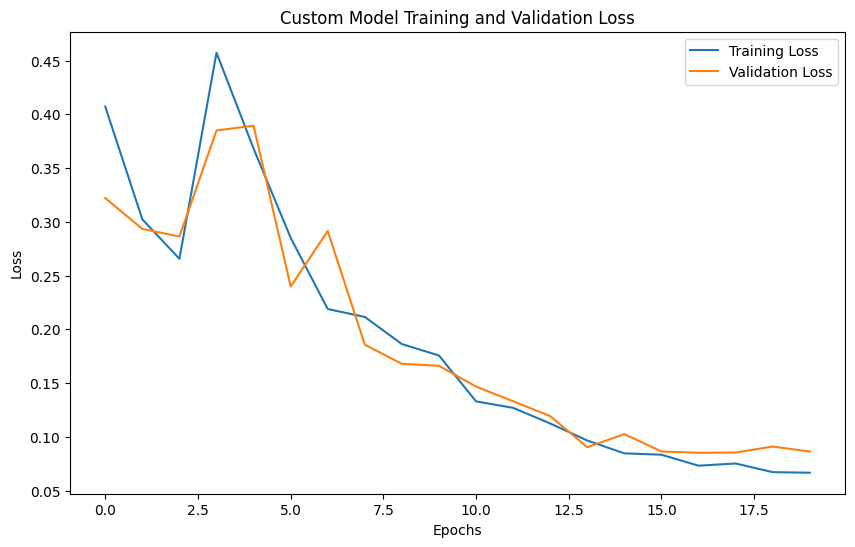

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9586 - loss: 0.1118
Custom Model Validation Accuracy: 0.97
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

      Normal       0.97      1.00      0.98       700
Tuberculosis       1.00      0.83      0.91       142

    accuracy                           0.97       842
   macro avg       0.98      0.92      0.95       842
weighted avg       0.97      0.97      0.97       842



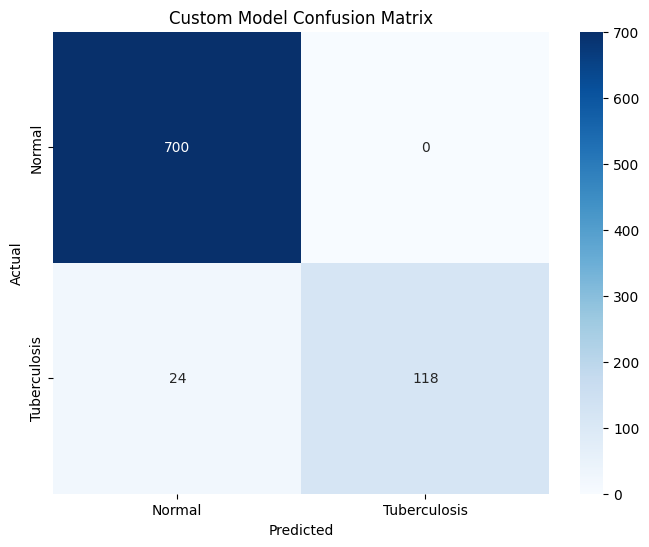

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8571 - loss: 1.0520 - val_accuracy: 0.9786 - val_loss: 0.0688
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9791 - loss: 0.0548 - val_accuracy: 0.9893 - val_loss: 0.0390
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9848 - loss: 0.0376 - val_accuracy: 0.9834 - val_loss: 0.0450
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9900 - loss: 0.0267 - val_accuracy: 0.9822 - val_loss: 0.0482
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9907 - loss: 0.0268 - val_accuracy: 0.9881 - val_loss: 0.0308
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9926 - loss: 0.0247 - val_accuracy: 0.9881 - val_loss: 0.0293
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 0.9881 - val_loss: 0.0345
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9953 - loss: 0.0120 - val_accu

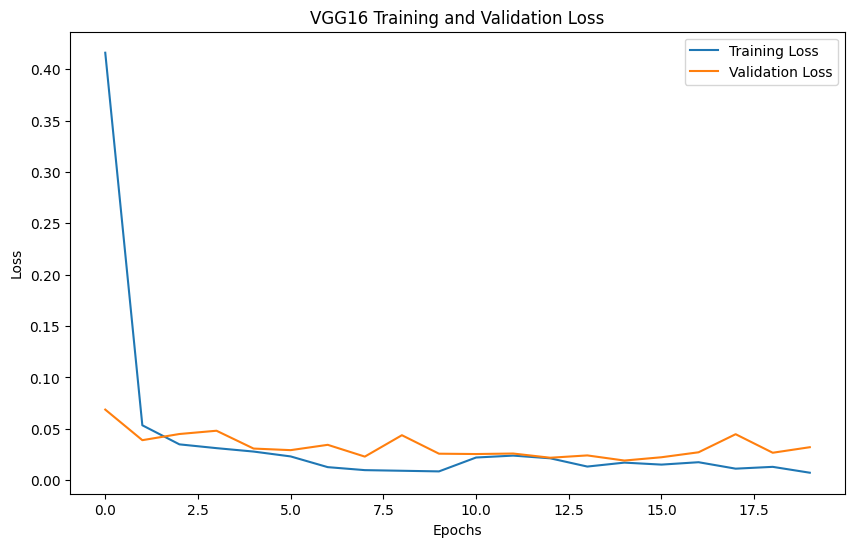

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9955 - loss: 0.0170
VGG16 Validation Accuracy: 0.99
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       700
Tuberculosis       0.98      0.99      0.98       142

    accuracy                           0.99       842
   macro avg       0.99      0.99      0.99       842
weighted avg       0.99      0.99      0.99       842



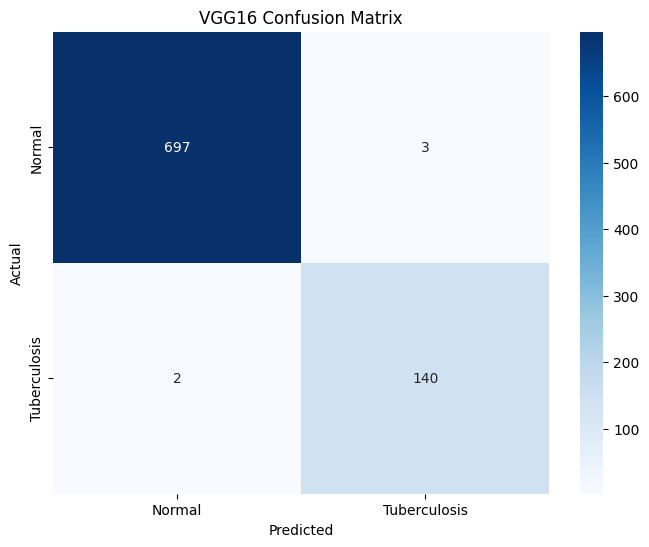

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.8523 - loss: 0.4822 - val_accuracy: 0.9774 - val_loss: 0.0652
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9752 - loss: 0.0746 - val_accuracy: 0.9786 - val_loss: 0.0548
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9787 - loss: 0.0521 - val_accuracy: 0.9798 - val_loss: 0.0499
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9877 - loss: 0.0465 - val_accuracy: 0.9846 - val_loss: 0.0394
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9887 - loss: 0.0358 - val_accuracy: 0.9917 - val_loss: 0.0313
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9893 - loss: 0.0328 - val_accuracy: 0.9786 - val_loss: 0.0523
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9918 - loss: 0.0319 - val_accuracy: 0.9905 - val_loss: 0.0249
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9942 - loss: 0.0199 - val_ac

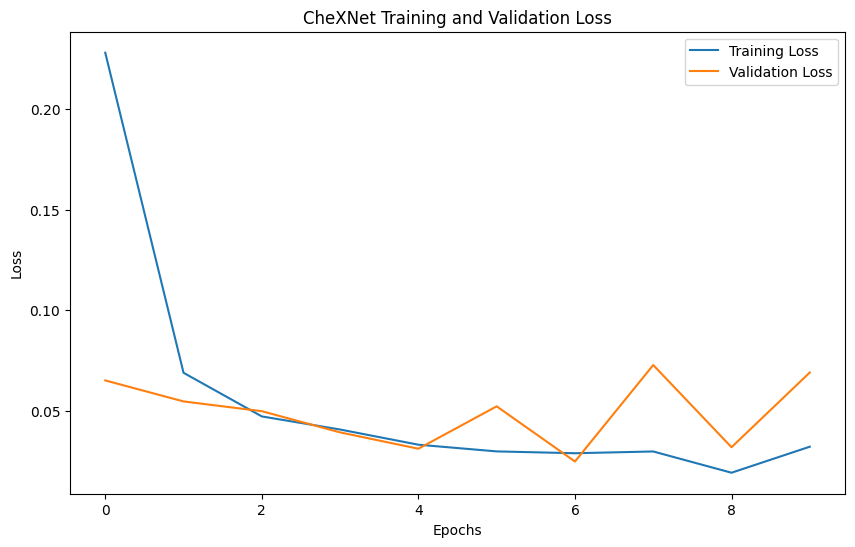

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9767 - loss: 0.0599
CheXNet Validation Accuracy: 0.98
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 334ms/step
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       700
Tuberculosis       0.98      0.89      0.93       142

    accuracy                           0.98       842
   macro avg       0.98      0.94      0.96       842
weighted avg       0.98      0.98      0.98       842



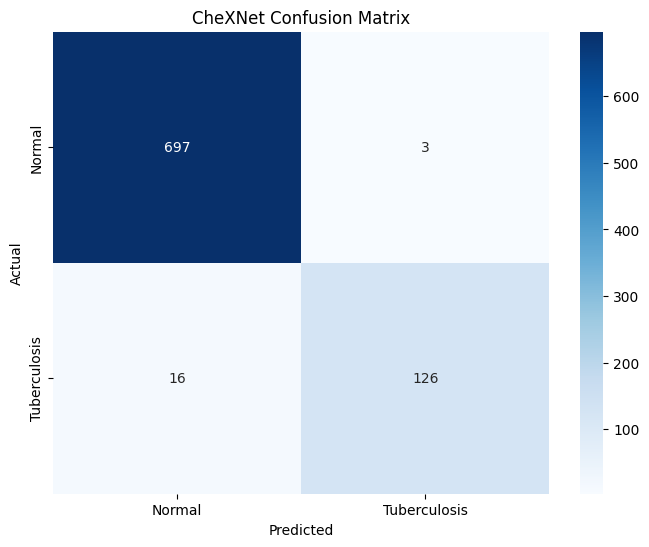

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 64s 325ms/step - accuracy: 0.8793 - loss: 0.3618 - val_accuracy: 0.9822 - val_loss: 0.0564
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9825 - loss: 0.0564 - val_accuracy: 0.9739 - val_loss: 0.0613
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9861 - loss: 0.0436 - val_accuracy: 0.9929 - val_loss: 0.0311
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9917 - loss: 0.0235 - val_accuracy: 0.9952 - val_loss: 0.0262
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9915 - loss: 0.0268 - val_accuracy: 0.9929 - val_loss: 0.0281
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9945 - loss: 0.0167 - val_accuracy: 0.9917 - val_loss: 0.0290
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9909 - loss: 0.0230 - val_accuracy: 0.9941 - val_loss: 0.0238
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9952 - loss: 0.0123 - val_ac

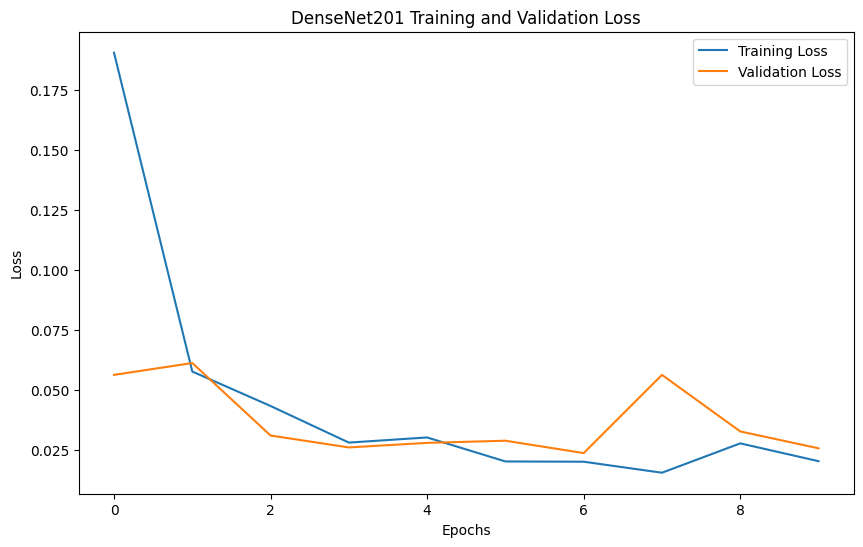

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9818 - loss: 0.0537
DenseNet201 Validation Accuracy: 0.98
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 577ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99       700
Tuberculosis       0.97      0.92      0.95       142

    accuracy                           0.98       842
   macro avg       0.98      0.96      0.97       842
weighted avg       0.98      0.98      0.98       842



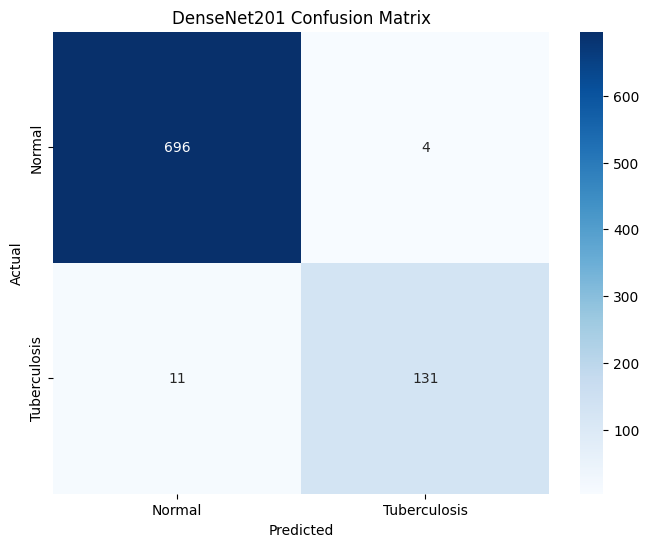

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data1, train_labels1['label'], test_size=0.2, random_state=42, stratify=train_labels1['label'])

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Function to plot training and validation loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Define a function to train and evaluate a model
def train_and_evaluate(model, model_name):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        epochs=20,
        validation_data=(X_val, y_val),
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    plot_training_history(history, model_name)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
    print(f"{model_name} Validation Accuracy: {val_acc:.2f}")
    return model, history

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return cm

# Function to generate predictions and confusion matrix
def evaluate_model(model, model_name):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Tuberculosis']))
    plot_confusion_matrix(y_true, y_pred_classes, ['Normal', 'Tuberculosis'], model_name)

# 1. Custom CNN Model
custom_model = Sequential([
    Input(shape=(224, 224, 3)),  # Update the input shape to match resized images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),  # Reduce spatial dimensions
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for 2 classes
])
custom_model, custom_history = train_and_evaluate(custom_model, "Custom Model")
evaluate_model(custom_model, "Custom Model")

# 2. VGG16 Model
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False
vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
vgg16_model, vgg16_history = train_and_evaluate(vgg16_model, "VGG16")
evaluate_model(vgg16_model, "VGG16")

# 3. CheXNet (DenseNet121 Pre-trained on ImageNet)
chexnet_base = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
chexnet_base.trainable = False
chexnet_model = Sequential([
    chexnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
chexnet_model, chexnet_history = train_and_evaluate(chexnet_model, "CheXNet")
evaluate_model(chexnet_model, "CheXNet")

# 4. DenseNet201 Model
densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet201_base.trainable = False
densenet201_model = Sequential([
    densenet201_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
densenet201_model, densenet201_history = train_and_evaluate(densenet201_model, "DenseNet201")
evaluate_model(densenet201_model, "DenseNet201")
